In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
input_path = 'H:\RediMinds\VCQI'
train = pd.read_csv(input_path+"\VCQI_clean_train_30_day_complications.csv")
test = pd.read_csv(input_path+"\VCQI_clean_test_30_day_complications.csv")

In [3]:
target = '30_day_COMPLICATIONS'
x_train = train.drop(labels=target, axis = 'columns').copy()
y_train = train[target].copy()
x_test = test.drop(labels=target, axis = 'columns').copy()
y_test = test[target].copy() 

In [4]:
print('% pos labels train {:.2f}'.format(y_train.sum()/len(y_train)))
print('% pos labels test {:.2f}'.format(y_test.sum()/len(y_test)))

% pos labels train 0.09
% pos labels test 0.09


In [5]:
# Define Pipeline transformation steps
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


sm = SMOTE(random_state=2)
numeric_features = x_train.select_dtypes('float').columns.tolist()
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)], remainder='passthrough')

Using TensorFlow backend.


# Decision Tree Classifier

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import math
DTC = DecisionTreeClassifier()
parameter_dist = {'DTC__max_features':['sqrt','log2',None],
                  'DTC__min_samples_leaf': [1,5,10,15,20,25,30,35,40,45,50], 
                  'DTC__class_weight' :[None,'balanced'], 
                  'DTC__random_state': [1234]}


clf = Pipeline(steps=[('SMOTE',sm),
                      ('DTC', DecisionTreeClassifier())])
classifier_DTC = GridSearchCV(clf, parameter_dist, n_jobs = -1, scoring = 'roc_auc', cv = 10 )
results_classifier_DTC = classifier_DTC.fit(x_train, y_train)
y_DTC = results_classifier_DTC.predict(x_test)


In [7]:
classifier = results_classifier_DTC
results_DTC = pd.DataFrame(classifier.predict(x_test), columns=['pred_label'])
results_DTC['pred_prob'] =  pd.DataFrame(classifier.predict_proba(x_test))[1]
results_DTC['true_label'] = np.array(y_test)

In [8]:
# Decison Tree Score Raw Data
print(classifier.best_params_)
print("\n Model Best CV score: \n" + str(classifier.best_score_))
print("\n Model Balanced Accuracy: \n" + str(metrics.balanced_accuracy_score(y_test, y_DTC)))
print("\n Confusion Matrix : \n"+str(metrics.confusion_matrix(y_test, y_DTC)))
print("\n Classification Report: \n"+ str(metrics.classification_report(y_test, y_DTC)))
print("\n AUC-ROC: \n"+ str(metrics.roc_auc_score(y_test, results_DTC['pred_prob'])))

def calc_aucpr_data(result):
    y_ACTUAL = result['true_label']
    scores_prob = result['pred_prob']
    yhat = result['pred_label']
    precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
    prc_auc = metrics.auc(recall,precision)
    return prc_auc

print("\n PR-ROC: \n"+ str(calc_aucpr_data(results_DTC)))

{'DTC__class_weight': None, 'DTC__max_features': 'sqrt', 'DTC__min_samples_leaf': 25, 'DTC__random_state': 1234}

 Model Best CV score: 
0.762813461190701

 Model Balanced Accuracy: 
0.5334844872713935

 Confusion Matrix : 
[[730  49]
 [ 67  10]]

 Classification Report: 
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       779
           1       0.17      0.13      0.15        77

    accuracy                           0.86       856
   macro avg       0.54      0.53      0.54       856
weighted avg       0.85      0.86      0.86       856


 AUC-ROC: 
0.7463864761682476

 PR-ROC: 
0.16679999542023408


In [9]:
def bootstrapped_AUC(result):
    from sklearn.utils import resample
    from tqdm import tqdm

    n_iter = 10000
    roc_auc = list()
    prc_auc = list()


    for i in range(n_iter):
        result_sample = resample(result, n_samples = len(result),random_state=i)
        
        #Calculating AUROC for each sample
        y_ACTUAL= result_sample['true_label']
        scores_prob = result_sample['pred_prob']
        fpr, tpr, thresholds = metrics.roc_curve(y_ACTUAL, scores_prob, pos_label=1)
        roc_auc.append(metrics.auc(fpr, tpr))

        #calculate AUPRC for each sample
        y_ACTUAL = result_sample['true_label']
        scores_prob = result_sample['pred_prob']
        yhat = result_sample['pred_label']
        precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
        prc_auc.append(metrics.auc(recall,precision))
    
    return roc_auc, prc_auc

In [10]:
roc_auc_DTC, pr_auc_DTC = bootstrapped_AUC(results_DTC)

In [11]:
dict = {'roc_auc_DTC': roc_auc_DTC,
        'pr_auc_DTC': pr_auc_DTC,
       }
pd.DataFrame(dict).describe(percentiles=[0.025,0.975])

,roc_auc_DTC,pr_auc_DTC
count,10000.000000,10000.000000
mean,0.746554,0.169156
std,0.023581,0.024078
min,0.645703,0.087643
2.5%,0.699445,0.125314
50%,0.746872,0.167849
97.5%,0.791160,0.219980
max,0.829124,0.280567


# Random Forest Classifier

In [12]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import math
RFC = RandomForestClassifier(random_state= 42)
parameter_dist = {'RFC__n_estimators': [100,200,300,500], 
                  'RFC__max_features':['sqrt','log2',None],
                  'RFC__min_samples_leaf': [5,10,20,25,30,35,40,45,50], 
                  'RFC__class_weight' :[None, 'balanced'] 
} 

clf = Pipeline(steps=[('SMOTE',sm),
                      ('RFC', RandomForestClassifier(random_state= 42))])
classifier_RFR = GridSearchCV(clf, parameter_dist, n_jobs = -1,cv=10, scoring = 'recall', return_train_score=True)
results_classifier_RFR = classifier_RFR.fit(x_train, y_train)
y_RFR = results_classifier_RFR.predict(x_test)


H:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [13]:
classifier = results_classifier_RFR
results_RFR = pd.DataFrame(classifier.predict(x_test), columns=['pred_label'])
results_RFR['pred_prob'] =  pd.DataFrame(classifier.predict_proba(x_test))[1]
results_RFR['true_label'] = np.array(y_test)

In [14]:
# Random Forest Classifier Score Raw Data
print(classifier.best_params_)
print("\n Model Best CV score: \n" + str(classifier.best_score_))
print("\n Model Balanced Accuracy: \n" + str(metrics.balanced_accuracy_score(y_test, y_RFR)))
print("\n Confusion Matrix : \n"+str(metrics.confusion_matrix(y_test, y_RFR)))
print("\n Classification Report: \n"+ str(metrics.classification_report(y_test, y_RFR)))
print("\n AUC-ROC: \n"+ str(metrics.roc_auc_score(y_test, results_RFR['pred_prob'])))

def calc_aucpr_data(result):
    y_ACTUAL = result['true_label']
    scores_prob = result['pred_prob']
    yhat = result['pred_label']
    precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
    prc_auc = metrics.auc(recall,precision)
    return prc_auc

print("\n PR-ROC: \n"+ str(calc_aucpr_data(results_RFR)))

{'RFC__class_weight': None, 'RFC__max_features': 'log2', 'RFC__min_samples_leaf': 50, 'RFC__n_estimators': 200}

 Model Best CV score: 
0.30740413124314053

 Model Balanced Accuracy: 
0.6075554740509811

 Confusion Matrix : 
[[724  55]
 [ 55  22]]

 Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       779
           1       0.29      0.29      0.29        77

    accuracy                           0.87       856
   macro avg       0.61      0.61      0.61       856
weighted avg       0.87      0.87      0.87       856


 AUC-ROC: 
0.8299851624626978

 PR-ROC: 
0.3013189268652281


In [17]:
roc_auc_RFR, pr_auc_RFR = bootstrapped_AUC(results_RFR)

In [18]:
dict = {'roc_auc_RFR': roc_auc_RFR,
        'pr_auc_RFR': pr_auc_RFR,
       }
pd.DataFrame(dict).describe(percentiles=[0.025,0.975])

,roc_auc_RFR,pr_auc_RFR
count,10000.000000,10000.000000
mean,0.829786,0.303204
std,0.020438,0.046577
min,0.740408,0.138279
2.5%,0.787742,0.214872
50%,0.830392,0.301982
97.5%,0.867855,0.396183
max,0.890540,0.486435


# Prepare data for Logistic Regression

In [19]:
# Create dummy variables
with open (input_path+'\cat_col_30_day_complications', 'rb') as fp:
    cat_col = pickle.load(fp)

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(categories='auto',handle_unknown='ignore')

logit_train = train.copy()
one_hot_encoded_array = encoder.fit_transform(train[cat_col]).toarray()
column_name = encoder.get_feature_names(cat_col)
logit_train_one =  pd.DataFrame(one_hot_encoded_array, columns= column_name)
logit_train = logit_train.merge(logit_train_one, how = 'left', left_index = True, right_index =True) # create dummy variables
logit_train = logit_train.drop(labels = cat_col, axis = 'columns') # drop original variables

In [20]:
logit_train.head()

,AGEATSURGERY,BMI,CLINICALSIZEmm,PREOPHB,PREOPHT,PREOPWBC,PREOPCREAT,PREOPEGFR,NOOFLESIONS,30_day_COMPLICATIONS,...,LOCATIONTOPOLARLINE_1,LOCATIONTOPOLARLINE_2,LOCATIONTOPOLARLINE_3,PARTIALNEPHROINDICATION_0,PARTIALNEPHROINDICATION_1,PARTIALNEPHROINDICATION_2,PARTIALNEPHROINDICATION_3,MULTIFOCALITY_0,MULTIFOCALITY_1,MULTIFOCALITY_2
0,57.0,25.84,29.0,14.70,42.40,9400.00,0.86,91.66000,1.00,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,78.0,31.64,24.8,14.90,44.30,6600.00,0.90,81.61000,1.00,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,43.0,24.74,28.0,16.10,46.70,8000.00,1.20,66.08000,1.00,0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,72.0,24.60,25.0,13.91,41.56,7205.87,0.83,67.57520,1.05,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,55.0,24.00,19.0,13.91,41.56,7205.87,1.04,55.01636,1.00,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [21]:
logit_test = test.copy()
one_hot_encoded_array = encoder.transform(test[cat_col]).toarray()
column_name = encoder.get_feature_names(cat_col)
logit_test_one =  pd.DataFrame(one_hot_encoded_array, columns= column_name)
logit_test = logit_test.merge(logit_test_one, how = 'left', left_index = True, right_index =True) # create dummy variables
logit_test = logit_test.drop(labels = cat_col, axis = 'columns') # drop original variables

In [22]:
logit_test.head()

,AGEATSURGERY,BMI,CLINICALSIZEmm,PREOPHB,PREOPHT,PREOPWBC,PREOPCREAT,PREOPEGFR,NOOFLESIONS,30_day_COMPLICATIONS,...,LOCATIONTOPOLARLINE_1,LOCATIONTOPOLARLINE_2,LOCATIONTOPOLARLINE_3,PARTIALNEPHROINDICATION_0,PARTIALNEPHROINDICATION_1,PARTIALNEPHROINDICATION_2,PARTIALNEPHROINDICATION_3,MULTIFOCALITY_0,MULTIFOCALITY_1,MULTIFOCALITY_2
0,65.0,28.80,45.0,11.50,33.00,3000.00,1.00,55.64,1.00,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,30.0,24.09,40.0,16.20,46.50,5500.00,0.85,105.84,1.00,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,53.0,28.10,65.0,14.90,42.90,6700.00,0.72,84.73,1.00,0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,76.0,36.20,31.0,13.91,41.56,7205.87,0.63,132.00,1.05,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,71.0,24.30,46.0,13.40,39.40,5820.00,0.89,84.26,1.00,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [23]:
x_train = logit_train.drop(labels=target, axis = 'columns').copy()
y_train = logit_train[target].copy()
x_test = logit_test.drop(labels=target, axis = 'columns').copy()
y_test = logit_test[target].copy()

In [24]:
print("Number of records in trainset {}".format(len(x_train)))
print("Number records in testset {}".format(len(x_test)))
print('% pos labels train {:.2f}'.format(y_train.sum()/len(y_train)))
print('% pos labels test {:.2f}'.format(y_test.sum()/len(y_test)))

Number of records in trainset 1995
Number records in testset 856
% pos labels train 0.09
% pos labels test 0.09


In [25]:
x_train.describe()

,AGEATSURGERY,BMI,CLINICALSIZEmm,PREOPHB,PREOPHT,PREOPWBC,PREOPCREAT,PREOPEGFR,NOOFLESIONS,GENDER_0,...,LOCATIONTOPOLARLINE_1,LOCATIONTOPOLARLINE_2,LOCATIONTOPOLARLINE_3,PARTIALNEPHROINDICATION_0,PARTIALNEPHROINDICATION_1,PARTIALNEPHROINDICATION_2,PARTIALNEPHROINDICATION_3,MULTIFOCALITY_0,MULTIFOCALITY_1,MULTIFOCALITY_2
count,1995.000000,1995.000000,1995.000000,1995.000000,1995.000000,1995.000000,1995.000000,1995.000000,1995.000000,1995.000000,...,1995.000000,1995.000000,1995.000000,1995.000000,1995.000000,1995.000000,1995.000000,1995.000000,1995.000000,1995.000000
mean,57.512346,28.110265,31.763138,13.918762,41.580070,7236.334762,0.928265,80.886743,1.044386,0.345865,...,0.180451,0.160902,0.426065,0.021053,0.602506,0.278697,0.097744,0.394486,0.574436,0.031078
std,12.463029,4.763373,13.458204,1.248355,3.552078,1531.388158,0.206800,16.057862,0.213625,0.475769,...,0.384659,0.367533,0.494627,0.143596,0.489502,0.448470,0.297043,0.488863,0.494552,0.173571
min,16.000000,15.100000,0.000000,10.000000,30.000000,2700.000000,0.400000,36.090000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50.000000,24.800000,22.000000,13.400000,40.200000,6600.000000,0.780000,71.060473,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,58.000000,28.080000,30.000000,13.910000,41.560000,7205.870000,0.910000,81.070000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,66.000000,30.705000,40.000000,14.600000,43.200000,7400.000000,1.050000,88.000000,1.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,89.000000,42.300000,71.000000,17.800000,53.700000,12840.000000,1.570000,136.080000,3.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
x_test.describe()

,AGEATSURGERY,BMI,CLINICALSIZEmm,PREOPHB,PREOPHT,PREOPWBC,PREOPCREAT,PREOPEGFR,NOOFLESIONS,GENDER_0,...,LOCATIONTOPOLARLINE_1,LOCATIONTOPOLARLINE_2,LOCATIONTOPOLARLINE_3,PARTIALNEPHROINDICATION_0,PARTIALNEPHROINDICATION_1,PARTIALNEPHROINDICATION_2,PARTIALNEPHROINDICATION_3,MULTIFOCALITY_0,MULTIFOCALITY_1,MULTIFOCALITY_2
count,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000,...,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000
mean,57.699252,28.079110,31.749907,13.898400,41.505561,7134.871671,0.926926,81.488574,1.053037,0.353972,...,0.195093,0.181075,0.406542,0.030374,0.599299,0.275701,0.094626,0.400701,0.567757,0.031542
std,12.689548,4.679229,13.682328,1.256784,3.604012,1464.441578,0.209847,17.267054,0.241734,0.478480,...,0.396504,0.385305,0.491475,0.171714,0.490327,0.447128,0.292869,0.490327,0.495677,0.174880
min,18.000000,16.120000,1.800000,10.000000,29.800000,1840.000000,0.360000,34.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,49.000000,25.000000,22.000000,13.300000,39.900000,6600.000000,0.780000,72.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,58.000000,28.100000,31.000000,13.910000,41.560000,7205.870000,0.900000,81.070000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,67.000000,30.602500,40.000000,14.500000,43.200000,7400.000000,1.042500,89.052500,1.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,86.000000,42.000000,71.000000,17.700000,51.100000,12800.000000,1.550000,135.579610,4.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
#from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

In [28]:
sm = SMOTE(random_state=2)
numeric_features = x_train.select_dtypes('float').columns.tolist()
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)], remainder='passthrough')

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import math
model = LogisticRegression()
parameter_dist = {'classifier__solver':['saga','liblinear','newton-cg','lbfgs'],
                  'classifier__class_weight': [None, 'balanced'] ,
                  'classifier__penalty':['l2'],
                  'classifier__max_iter':[10000],
                  'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
                 }


clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('SMOTE',sm),
                      ('classifier', LogisticRegression())])
logit = GridSearchCV(clf,parameter_dist,n_jobs=-1,scoring='recall', cv = 5)

In [30]:
#train and fit to original data
classifier_logit = logit.fit(x_train, y_train)
y_logit = classifier_logit.predict(x_test)

In [31]:
classifier = classifier_logit
results_logit = pd.DataFrame(classifier.predict(x_test), columns=['pred_label'])
results_logit['pred_prob'] =  pd.DataFrame(classifier.predict_proba(x_test))[1]
results_logit['true_label'] = np.array(y_test)

In [32]:
# Logistic Regression Score Raw Data
print(classifier.best_params_)
print("\n Model Best CV score: \n" + str(classifier.best_score_))
print("\n Model Balanced Accuracy: \n" + str(metrics.balanced_accuracy_score(y_test, y_logit)))
print("\n Confusion Matrix : \n"+str(metrics.confusion_matrix(y_test, y_logit)))
print("\n Classification Report: \n"+ str(metrics.classification_report(y_test, y_logit)))
print("\n AUC-ROC: \n"+ str(metrics.roc_auc_score(y_test, results_logit['pred_prob'])))

def calc_aucpr_data(result):
    y_ACTUAL = result['true_label']
    scores_prob = result['pred_prob']
    yhat = result['pred_label']
    precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
    prc_auc = metrics.auc(recall,precision)
    return prc_auc

print("\n PR-ROC: \n"+ str(calc_aucpr_data(results_logit)))

{'classifier__C': 0.001, 'classifier__class_weight': None, 'classifier__max_iter': 10000, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}

 Model Best CV score: 
0.8777081592871067

 Model Balanced Accuracy: 
0.7561392394511779

 Confusion Matrix : 
[[480 299]
 [  8  69]]

 Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.62      0.76       779
           1       0.19      0.90      0.31        77

    accuracy                           0.64       856
   macro avg       0.59      0.76      0.53       856
weighted avg       0.91      0.64      0.72       856


 AUC-ROC: 
0.8302519047063335

 PR-ROC: 
0.35061981767514155


In [33]:
roc_auc_logit, pr_auc_logit = bootstrapped_AUC(results_logit)

In [34]:
dict = {'roc_auc_logit': roc_auc_logit,
        'pr_auc_logit': pr_auc_logit,
       }
pd.DataFrame(dict).describe(percentiles=[0.025,0.975])

,roc_auc_logit,pr_auc_logit
count,10000.000000,10000.000000
mean,0.830049,0.351982
std,0.020476,0.053153
min,0.752794,0.181402
2.5%,0.787901,0.249364
50%,0.830667,0.351289
97.5%,0.868061,0.458171
max,0.905357,0.545097


# Compare Classifiers

H:\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


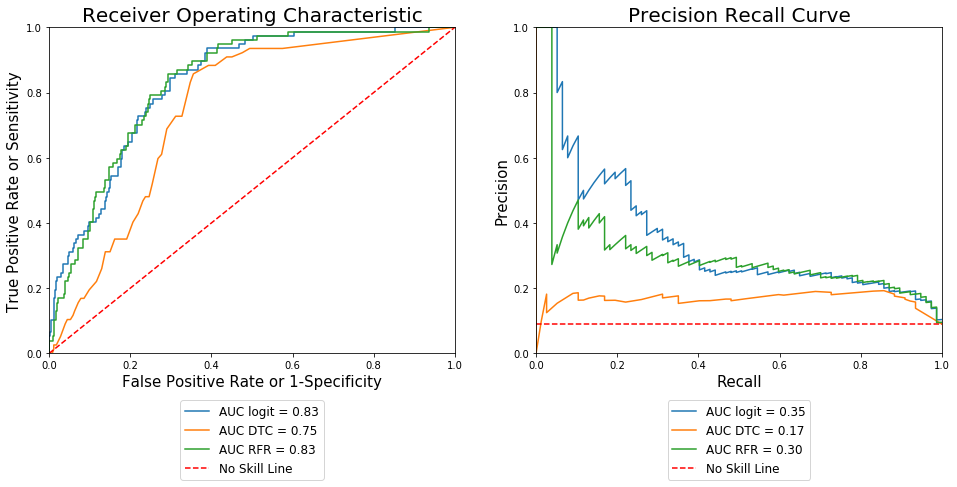

In [36]:
# Plotting AUROC Curve - Calculatae Metrics
from sklearn import metrics
def calc_aucroc_data(result):
    y_ACTUAL= result['true_label']
    scores_prob = result['pred_prob']
    fpr, tpr, thresholds = metrics.roc_curve(y_ACTUAL, scores_prob, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    return fpr, tpr, thresholds, roc_auc

def calc_aucpr_data(result):
    y_ACTUAL = result['true_label']
    scores_prob = result['pred_prob']
    yhat = result['pred_label']
    precision, recall, thresholds = metrics.precision_recall_curve(y_ACTUAL, scores_prob, pos_label=1)
    prc_auc = metrics.auc(recall,precision)
    f1 = metrics.f1_score(y_ACTUAL, yhat)
    ap = metrics.average_precision_score(y_ACTUAL, yhat)
    postives_ratio = round(sum(result['true_label'])/(len(result['true_label'])),2)
    return recall, precision, f1, prc_auc, postives_ratio

fpr_logit, tpr_logit, thresholds_logit, roc_auc_logit = calc_aucroc_data(results_logit)
recall_logit, precision_logit, f1_logit, prc_auc_logit, postives_ratio_logit = calc_aucpr_data(results_logit)

fpr_DTC, tpr_DTC, thresholds_DTC, roc_auc_DTC = calc_aucroc_data(results_DTC)
recall_DTC, precision_DTC, f1_DTC, prc_auc_DTC, postives_ratio_DTC = calc_aucpr_data(results_DTC)

fpr_RFR, tpr_RFR, thresholds_RFR, roc_auc_RFR = calc_aucroc_data(results_RFR)
recall_RFR, precision_RFR, f1_RFR, prc_auc_RFR, postives_ratio_RFR = calc_aucpr_data(results_RFR)


import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6))

# Plotting AUROC Curve - Plot Curve
ax1.set_title('Receiver Operating Characteristic',fontdict={"size":20})
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate or Sensitivity', fontdict={"size":15})
ax1.set_xlabel('False Positive Rate or 1-Specificity',fontdict={"size":15})
ax1.plot(fpr_logit, tpr_logit, label = 'AUC logit = %0.2f' % roc_auc_logit)
ax1.plot(fpr_DTC, tpr_DTC, label = 'AUC DTC = %0.2f' % roc_auc_DTC)
ax1.plot(fpr_RFR, tpr_RFR, label = 'AUC RFR = %0.2f' % roc_auc_RFR)
ax1.plot([0, 1], [0, 1],linestyle='--',color='red', label = 'No Skill Line')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125), fontsize = 12)  

# Plotting Precision-Recall Curve - PLot Curve
ax2.set_title('Precision Recall Curve',fontdict={"size":20})
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_ylabel('Precision',fontdict={"size":15})
ax2.set_xlabel('Recall',fontdict={"size":15})
ax2.plot(recall_logit, precision_logit, label = 'AUC logit = %.2f' % (prc_auc_logit))
ax2.plot(recall_DTC, precision_DTC, label = 'AUC DTC = %.2f' % (prc_auc_DTC))
ax2.plot(recall_RFR, precision_RFR, label = 'AUC RFR = %.2f' % (prc_auc_RFR))
positive_class_ratio = postives_ratio_logit
ax2.plot([0, 1], [positive_class_ratio, positive_class_ratio],linestyle='--',color='red', label = 'No Skill Line')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125),fontsize = 12)

fig.show()



In [37]:
output_path = 'output/models'

In [38]:
import os
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [39]:
# Export Decision Tree Classifier with Pipeline
from joblib import dump
dump(classifier_DTC, output_path+'/SMOTE_DTC.joblib')

['output/models/SMOTE_DTC.joblib']

In [40]:
# Export Random Forest Classifer with Pipeline
from joblib import dump
dump(classifier_RFR, output_path+'/SMOTE_RFR.joblib')

['output/models/SMOTE_RFR.joblib']

In [41]:
# Export Random Forest Classifer with Pipeline
from joblib import dump
dump(classifier_logit, output_path+'/SMOTE_Logit.joblib')

['output/models/SMOTE_Logit.joblib']